# Analysis DNS consumption with multiple configurations

Configurations have different QPS and protocols used.
This notebook aims to visualize the difference of consumption between those configurations.
Later we will use models to predict the agregated consumption of those different configurations.
In those configurations, the cache is *always used* because the domain is always the same in the requests (example.com).

## What will visualisations will be shown

The different things we want to study are:
- First an analysis on queries:
    - Idle consumption
    - QPS for different protocols received/sent by DNS and PC
    - The agregated consumption in function of QPS (Query Per Second)
    - The agregated consumption in function of the protocol 
- Then analysis on PC metrics:
    - Visualisation of the metrics for different protocols and different QPS
    - Correlation matrix of all metrics with protocols and QPS in the metrics
- Visualisation of the predicted aggregated consumption made by different models

## The model training part

Different models will be train to predict the aggregated consumption of the DNS server (Random forest, XGBoost, Linear regression and LSTM).
The error will be measured using RMSE (Root Mean Square Error).
A MAPE (Mean Absolute Percentage Error) will give us the error % for all models trained.

## Data transformations

Different type of files are used for this analysis (.log and .csv). They will all be imported using Pandas creating DataFrames.
Here are all the files used:
- CSV files:
    - `cpu_power.csv` : Metrics for the cpu consumption
    - `io_power.csv` : Metrics for the I/O (Disk)
    - `nic_power.csv` : Metrics for the NIC (Network Interface Card)
    - `ram_power.csv` : Metrics fo the ram utilisation (only LLC-loads and LLC-store, Last Level Cache not really RAM but we can estimate ram consumption from it)
    - `yoctowatt.csv` : External measurements made with a YoctoPuce
- Log files:
    - `bind_queries_captired.log` : Queries captured by the Bind DNS
    - `dns_doh.log` : DoH queries captured by the server
    - `dns_tcp.log` : DoT queries captured by the server
    - `dns_udp.log` : UDP queries captured by the server

Log files are used for their queries received at the datetime given.
CSV files contain TimeSeries metrics.

All DataFrames are linked with Date time.

#### NaN gestion

Because all measures don't have the same frequency (100Hz for the YoctoPuce and 1Hz for the rest) and are not exactly synchronised, NaN values will be created when merging them.
NaN values will be interpolated for all measures metrics with `bfill` and NaN from logs will be set to 0.


In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [82]:
CONFIGURATIONS = {
    "QPS": [1, 10, 100, 500, 1000],
    "Protocols": ["udp", "dot", "doh"]
}

DURATION = 300 # seconds
ROOT = "../data/300_config_merged/"

## We need to collect all files from all those configurations

A function will help collect all files from one configuration.  
All configurations are stored in folders with name `{DURATION}s_{PROTOCOL}_{QPS}qps_{TIMESTAMP}`.  
To simplify this, folders will be collected ignoring the timestamp just with the begining of the folder name.  

#### Function to import and process log files

In [118]:
import os

def import_log_file(file_path, offset_seconds=0, offset_date=None):
    with open(file_path, "r", encoding="utf-8", errors="replace") as f:
        log_df = pd.DataFrame({"raw": f.read().splitlines()})
        
    pattern = r'^(?P<date>\d{2}-[A-Za-z]{3}-\d{4})\s+(?P<time>\d{2}:\d{2}:\d{2}\.\d+).*$'
    if offset_date:
        pattern = r'^(?P<time>\d{2}:\d{2}:\d{2}\.\d+).*$'
    
    log_df = log_df["raw"].str.extract(pattern)
    
    if offset_date:
        log_df["date"] = offset_date.strftime("%d-%b-%Y")

    log_df["datetime"] = pd.to_datetime(log_df["date"] + " " + log_df["time"], format="%d-%b-%Y %H:%M:%S.%f")
    log_df["datetime"] = log_df["datetime"] + pd.to_timedelta(-offset_seconds, unit='s')
    log_df = log_df.drop(columns=["date", "time"])

    log_df.dropna(inplace=True)
    date_offset = offset_date
    if offset_date is None and not log_df.empty:
        date_offset = log_df["datetime"].iloc[0].date()
    
    log_df = log_df.set_index("datetime").sort_index()
    
    if offset_date:
        return log_df
    return log_df,date_offset

def import_all_logs(folder_path, date_offset=None):
    log_files = [
        {
            "file_name": "bind_queries_captured.log",
            "col_name": "dns_bind_captured"
        },
        {
            "file_name": "dns_doh.log",
            "col_name": "dns_doh_captured"
        },
        {
            "file_name": "dns_tcp.log",
            "col_name": "dns_tcp_captured"
        },
        {
            "file_name": "dns_udp.log",
            "col_name": "dns_udp_captured"
        }
    ]

    dfs = []
    for log_file in log_files:
        file_path = os.path.join(folder_path, "logs", log_file["file_name"])
        if "captured" in log_file["file_name"]:
            df, date_offset_buff = import_log_file(file_path, offset_seconds=3600)
            if date_offset_buff:
                date_offset = date_offset_buff
        else:
            df = import_log_file(file_path, offset_seconds=3600, offset_date=date_offset)
        df = df.groupby("datetime").size().rename(log_file["col_name"]).reset_index()
        dfs.append(df)
        
    return dfs, date_offset

#### Function to import and process the 5 CSV files

In [84]:
def import_csv_files(folder_path):
    # Importing cpu_power.csv
    cpu_power = pd.read_csv(f"{folder_path}/measures/cpu_power.csv")
    # convert Time_Of_Day_Seconds to int
    cpu_power["datetime"] = pd.to_datetime(cpu_power["Time_Of_Day_Seconds"], unit='s')
    cpu_power.drop(columns=["Time_Of_Day_Seconds"], inplace=True)

    # Importing io_power.csv
    io_power = pd.read_csv(f"{folder_path}/measures/io_power.csv")
    io_power["datetime"] = pd.to_datetime(io_power["timestamp"], unit='s')
    io_power.drop(columns=["timestamp"], inplace=True)

    # Importing nic_power.csv
    nic_power = pd.read_csv(f"{folder_path}/measures/nic_power.csv")
    nic_power["datetime"] = pd.to_datetime(nic_power["timestamp"], unit='s')
    nic_power.drop(columns=["timestamp"], inplace=True)

    # Importing ram_power.csv
    ram_power = pd.read_csv(f"{folder_path}/measures/ram_power.csv")
    ram_power["datetime"] = pd.to_datetime(ram_power["timestamp"], unit='s')
    ram_power.drop(columns=["timestamp"], inplace=True)

    # Importing yoctowatt.csv
    yoctowatt = pd.read_csv(f"{folder_path}/measures/yoctowatt.csv")
    yoctowatt["datetime"] = pd.to_datetime(yoctowatt["timestamp_unix"], unit='s')
    yoctowatt = yoctowatt.drop(columns=["reportFrequency_effective", "timestamp_iso", "timestamp_unix"])

    return [cpu_power, io_power, nic_power, ram_power, yoctowatt]

In [85]:
def collect_df_from_config(QPS, protocol):
    folder_name_start = f"{DURATION}s_{protocol}_{QPS}qps_"
    folder_name = next((f for f in os.listdir(ROOT) if f.startswith(folder_name_start)), None)
    
    logs_dfs, date_offset = import_all_logs(os.path.join(ROOT, folder_name))
    measures_dfs = import_csv_files(os.path.join(ROOT, folder_name))

    return {
        "logs": logs_dfs,
        "measures": measures_dfs,
        "QPS": QPS,
        "Protocol": protocol,
        "date_offset": date_offset
    }

In [86]:
def collect_idle_df(offset_date):
    folder_name_start = f"idle_"
    folder_name = next((f for f in os.listdir(ROOT) if f.startswith(folder_name_start)), None)

    logs_dfs, _ = import_all_logs(os.path.join(ROOT, folder_name), date_offset=offset_date)
    measures_dfs = import_csv_files(os.path.join(ROOT, folder_name))

    return {
        "logs": logs_dfs,
        "measures": measures_dfs,
        "QPS": 0,
        "Protocol": "idle"
    }

#### Collect all DataFrames from all configurations

In [119]:
configs = []
for protocol in CONFIGURATIONS["Protocols"]:
    for qps in CONFIGURATIONS["QPS"]:
        configs.append(collect_df_from_config(qps, protocol))
idle_config = collect_idle_df(offset_date=configs[0]["date_offset"])
configs.append(idle_config)

#### Check we have the correct number of configs imported

The number of configs should be equal to $n_c = n_p * n_q + 1$.  
With: 
- $n_c$ the number of configs
- $n_p$ the number of protocols
- $n_q$ the number of QPS  

This is multiplied by 2 if we take into account the cache and without cache for the DNS.  
The $+1$ is for the idle measurement

In [92]:
len(configs)

16

### Data transformation

Merge all DataFrames into one for each configurations

In [94]:
from functools import reduce

def merge_dataframes(config):
    merged_df = pd.DataFrame()
    
    # Merge all measures dataframes on datetime
    df_metrics = reduce(lambda left, right: pd.merge(left, right, on="datetime", how="outer"), config["measures"])
    
    # Merge all dns log dataframes on datetime
    df_dns = reduce(lambda left, right: pd.merge(left, right, on="datetime", how="outer"), config["logs"])

    # Merge metrics and dns dataframes on datetime
    df_full = pd.merge(df_metrics, df_dns, on="datetime", how="outer")
    df_full = df_full.sort_values("datetime").reset_index(drop=True)

    # Fill NaN values in query columns with 0 and backfill the rest
    queries_columns = df_dns.columns
    df_full[queries_columns] = df_full[queries_columns].fillna(0)
    df_full = df_full.bfill()

    return df_full

In [120]:
configs_merged = []
for config in configs:
    print(f"Merging dataframes for QPS={config['QPS']} and Protocol={config['Protocol']}...")
    df_merged = merge_dataframes(config)
    configs_merged.append({
        "df": df_merged,
        "QPS": config["QPS"],
        "Protocol": config["Protocol"]
    })

Merging dataframes for QPS=1 and Protocol=udp...
Merging dataframes for QPS=10 and Protocol=udp...
Merging dataframes for QPS=100 and Protocol=udp...
Merging dataframes for QPS=500 and Protocol=udp...
Merging dataframes for QPS=1000 and Protocol=udp...
Merging dataframes for QPS=1 and Protocol=dot...
Merging dataframes for QPS=10 and Protocol=dot...
Merging dataframes for QPS=100 and Protocol=dot...
Merging dataframes for QPS=500 and Protocol=dot...
Merging dataframes for QPS=1000 and Protocol=dot...
Merging dataframes for QPS=1 and Protocol=doh...
Merging dataframes for QPS=10 and Protocol=doh...
Merging dataframes for QPS=100 and Protocol=doh...
Merging dataframes for QPS=500 and Protocol=doh...
Merging dataframes for QPS=1000 and Protocol=doh...
Merging dataframes for QPS=0 and Protocol=idle...


## Queries focused analysis
### DNS server trafic comparison for all configurations

In [172]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

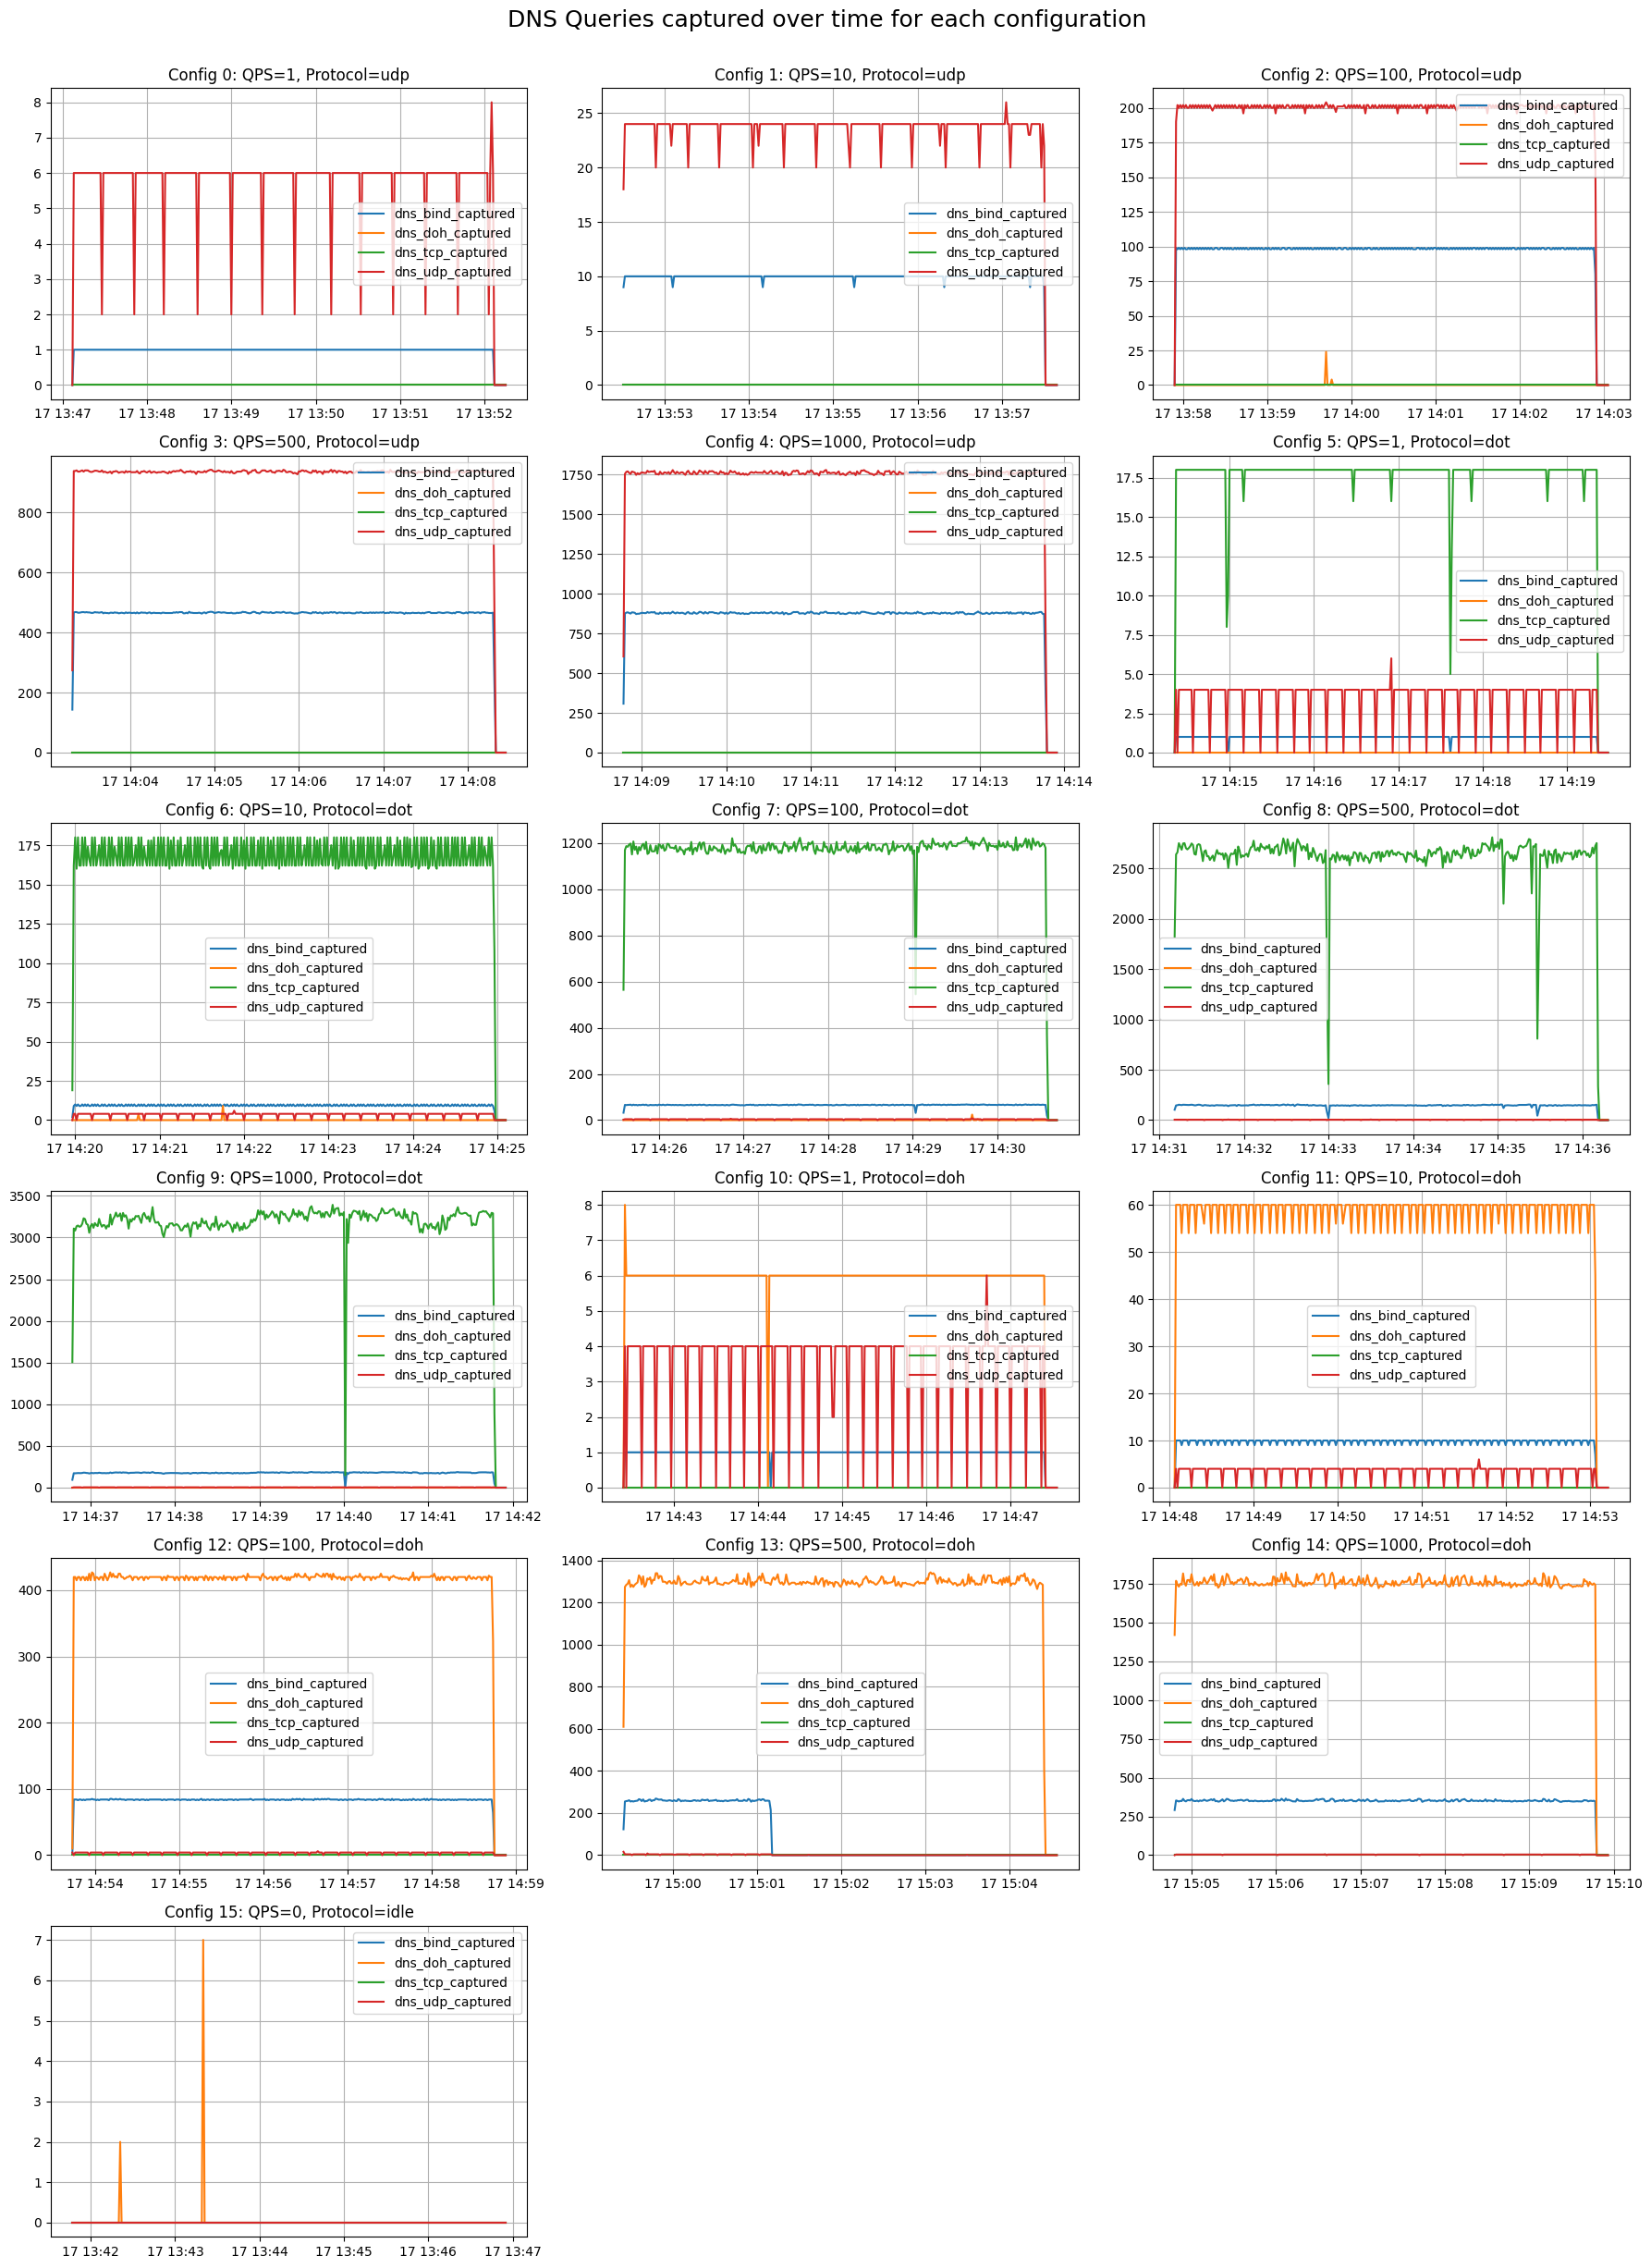

In [189]:
config_qps_cols = []
for config in configs_merged:
    cols = [c for c in config["df"].columns if c != "datetime" and "dns" in c]
    config_qps_cols.append(cols)

n_cols = 3
n_rows = int(np.ceil(len(config_qps_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for i, ax in enumerate(axes[:len(config_qps_cols)]):
    config = configs_merged[i]
    qps_cols = config_qps_cols[i]
    df_1s = config["df"][["datetime"] + qps_cols].set_index("datetime").resample("1s").sum()
    # Plot each column in the corresponding subplot
    for j, col in enumerate(qps_cols):
        # Resample to 1-second intervals and sum the counts
        df_1s[col] = df_1s[col].resample("1s").sum()
        ax.plot(df_1s.index, df_1s[col], label=col, color=colors[j])

    ax.set_title(f"Config {i}: QPS={config['QPS']}, Protocol={config['Protocol']}")
    ax.legend()
    ax.grid(True)
    
# Remove any unused subplots
for i in range(len(configs_merged), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
fig.suptitle("DNS Queries captured over time for each configuration", fontsize=18, y=1.02)
plt.show()

### Energy consumption per QPS for each Protocol

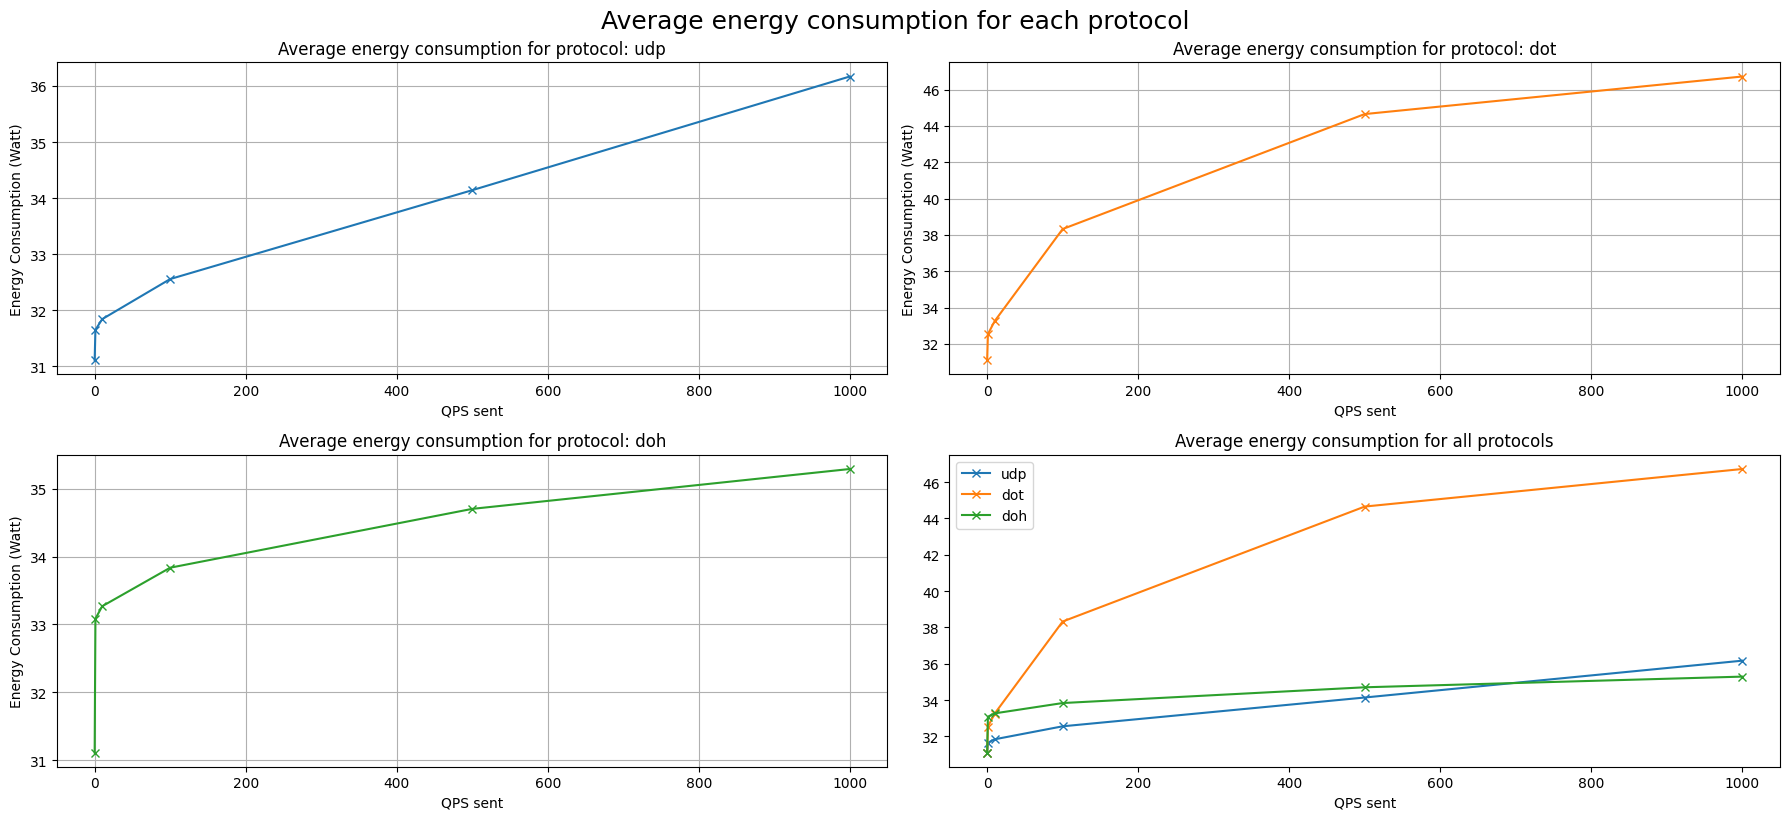

In [190]:
fig, axes = plt.subplots(2, 2, figsize=(18, 8))
axes = axes.flatten()

combined_consumption = {}

for i, protocol in enumerate(CONFIGURATIONS["Protocols"]):
    # Compute energy consumption for each QPS
    qps_consumption = []

    # Adding idle consumption
    df_idle = [config["df"] for config in configs_merged if config["Protocol"] == "idle"][0]
    idle_consumption = df_idle["watts"].mean()
    qps_consumption.append(idle_consumption)
    qps_list = [0]

    for qps in CONFIGURATIONS["QPS"]:
        df_target = [config["df"] for config in configs_merged if config["Protocol"] == protocol and config["QPS"] == qps][0]
        qps_consumption.append(df_target["watts"].mean())

    qps_list.extend(CONFIGURATIONS["QPS"])
    # Plot each protocol in the corresponding subplot
    ax = axes[i]
    ax.set_title(f"Average energy consumption for protocol: {protocol}")
    ax.plot(qps_list, qps_consumption, label=f"{protocol}", marker='x', color=colors[i])

    ax.set_xlabel("QPS sent")
    ax.set_ylabel("Energy Consumption (Watt)")
    ax.grid(True)

    combined_consumption[protocol] = (qps_list, qps_consumption)

# Plot combined energy consumption for all protocols
ax = axes[-1]
for i, (protocol, (qps_list, qps_consumption)) in enumerate(combined_consumption.items()):
    ax.plot(qps_list, qps_consumption, label=f"{protocol}", marker='x', color=colors[i])
ax.set_title("Average energy consumption for all protocols")
ax.set_xlabel("QPS sent")
ax.legend()

plt.tight_layout()
fig.suptitle("Average energy consumption for each protocol", fontsize=18, y=1.02)
plt.show()

There is a difference between the target QPS and the actual QPS processed by the DNS.  
These next graphs will help visualize with the actual QPS.

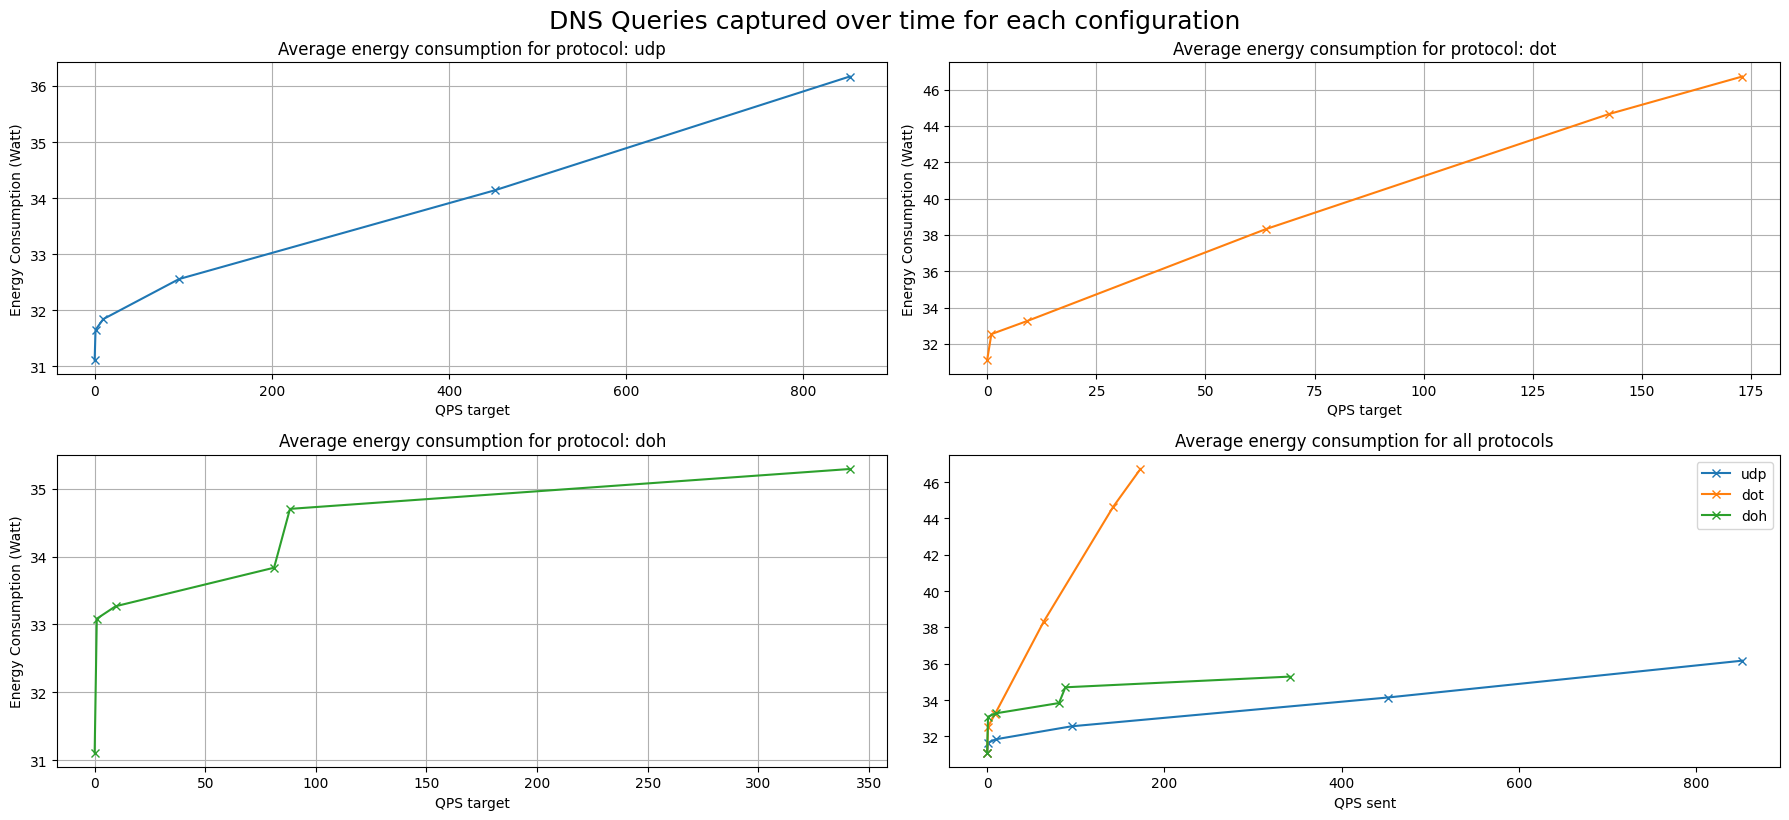

In [191]:
fig, axes = plt.subplots(2, 2, figsize=(18, 8))
axes = axes.flatten()

combined_consumption = {}

for i, protocol in enumerate(CONFIGURATIONS["Protocols"]):
    # Compute energy consumption for each QPS
    qps_consumption = []
    qps_diff = []

    # Adding idle consumption
    df_idle = [config["df"] for config in configs_merged if config["Protocol"] == "idle"][0]
    idle_consumption = df_idle["watts"].mean()
    qps_consumption.append(idle_consumption)
    qps_diff.append(0)

    for qps in CONFIGURATIONS["QPS"]:
        df_target = [config["df"] for config in configs_merged if config["Protocol"] == protocol and config["QPS"] == qps][0]
        df_1s = df_target[["datetime", "dns_bind_captured"]].set_index("datetime").resample("1s").sum()
        qps_diff.append(df_1s["dns_bind_captured"].mean())
        qps_consumption.append(df_target["watts"].mean())

    # Plot each protocol in the corresponding subplot
    ax = axes[i]
    ax.set_title(f"Average energy consumption for protocol: {protocol}")
    ax.plot(qps_diff, qps_consumption, label=f"{protocol}", marker='x', color=colors[i])

    ax.set_xlabel("QPS target")
    ax.set_ylabel("Energy Consumption (Watt)")
    ax.grid(True)

    combined_consumption[protocol] = (qps_diff, qps_consumption)

# Plot combined energy consumption for all protocols
ax = axes[-1]
for i, (protocol, (qps_list, qps_consumption)) in enumerate(combined_consumption.items()):
    ax.plot(qps_list, qps_consumption, label=f"{protocol}", marker='x', color=colors[i])
ax.set_title("Average energy consumption for all protocols")
ax.set_xlabel("QPS sent")
ax.legend()

plt.tight_layout()
fig.suptitle("DNS Queries captured over time for each configuration", fontsize=18, y=1.02)
plt.show()

### A lot of requests seem not to reach the DNS

To visualize that, here is graphs showing the difference between the sent requests and the requests received by the DNS.

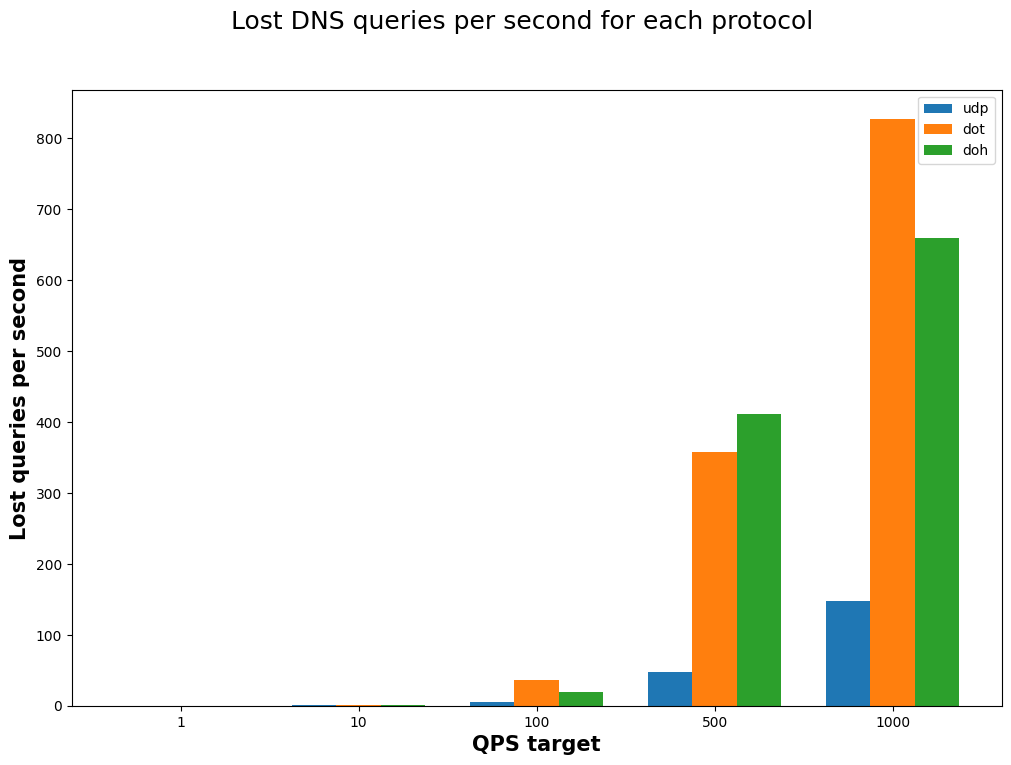

In [193]:
fig = plt.subplots(figsize =(12, 8)) 

qps_per_protocol = {}

for i, protocol in enumerate(CONFIGURATIONS["Protocols"]):
    # Compute energy consumption for each QPS
    qps_diff = []

    for qps in CONFIGURATIONS["QPS"]:
        df_target = [config["df"] for config in configs_merged if config["Protocol"] == protocol and config["QPS"] == qps][0]
        df_1s = df_target[["datetime", "dns_bind_captured"]].set_index("datetime").resample("1s").sum()
        dissmissed_qps = qps - df_1s["dns_bind_captured"].mean()
        qps_diff.append(dissmissed_qps)

    qps_per_protocol[protocol] = qps_diff

barWidth = 0.25
for i, protocol in enumerate(CONFIGURATIONS["Protocols"]):
    bar_pos = [r + i*barWidth for r in range(len(CONFIGURATIONS["QPS"]))]
    plt.bar(bar_pos, qps_per_protocol[protocol], width=barWidth, label=protocol, color=colors[i])

plt.xlabel('QPS target', fontweight ='bold', fontsize = 15) 
plt.ylabel('Lost queries per second', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(CONFIGURATIONS["QPS"]))], 
        CONFIGURATIONS["QPS"])
plt.legend()
plt.suptitle("Lost DNS queries per second for each protocol", fontsize=18)
plt.show() 

## Consumption metrics focused analysis

What I can analyse is for all configurations and metrics :
- Average 
- Standard deviation + max + min  

So a plot per protocol and values for all QPS.  

Globally, I can look at :
- Correlation between metrics and QPS 
- Plot the most correlated
- For each protocol, plot all metrics with all QPS (will be a lot)

I predict there will not be as much correlation because QPS is constant.  
